In [1]:
from regression import*

Using TensorFlow backend.


# Data

In [2]:
# Synthetic Training Data 
data_synth_dict = load_dataset('synth_00', as_dict=True)
data_synth_raw = DATA( data_synth_dict['vind'][:,50:], data_synth_dict['distance'][:,50:]) 

In [4]:
# Processing
win_size, step = 30, 5
data_synth_sgm = data_synth_raw.segment(win_size, step, as_df=True)    
# data_synth_sgm = data_synth_raw.MinMax().segment(win_size, step, as_df=True)    

In [5]:
exp_reg = setup(data_synth_sgm,
                train_size = .7,
                target = 'target', 
                # normalize = True, 
                silent = True,
                session_id = 10
                )   


Setup Succesfully Completed!


,Description,Value
0,session_id,10
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(51000, 31)"
4,Missing Values,False
5,Numeric Features,30
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [6]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.013900,0.000300,0.018000,0.699500,0.013700,0.044300
1,Extreme Gradient Boosting,0.014000,0.000300,0.018000,0.698700,0.013700,0.044400
2,Gradient Boosting Regressor,0.014000,0.000300,0.018000,0.698600,0.013700,0.044400
3,Light Gradient Boosting Machine,0.014000,0.000300,0.018100,0.697000,0.013700,0.044500
4,Random Forest,0.014800,0.000400,0.019000,0.665500,0.014400,0.046900
5,Extra Trees Regressor,0.015100,0.000400,0.019400,0.651500,0.014700,0.047900
6,K Neighbors Regressor,0.015300,0.000400,0.019600,0.645200,0.014800,0.048400
7,AdaBoost Regressor,0.015800,0.000400,0.019900,0.633900,0.015100,0.049600
8,Ridge Regression,0.015100,0.000400,0.020000,0.630900,0.015200,0.048200
9,Least Angle Regression,0.015100,0.000400,0.020000,0.630900,0.015200,0.048200


In [8]:
model = tune_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0140,0.0003,0.0178,0.7049,0.0135,0.0441
1,0.0141,0.0003,0.0181,0.7016,0.0138,0.0449
2,0.0140,0.0003,0.0182,0.6880,0.0138,0.0443
3,0.0142,0.0003,0.0183,0.6989,0.0139,0.0451
4,0.0143,0.0003,0.0185,0.7006,0.0141,0.0457
5,0.0140,0.0003,0.0179,0.7010,0.0136,0.0442
6,0.0147,0.0004,0.0190,0.6530,0.0144,0.0467
7,0.0146,0.0004,0.0190,0.6728,0.0144,0.0465
8,0.0141,0.0003,0.0182,0.6779,0.0138,0.0448
9,0.0141,0.0003,0.0184,0.6837,0.0139,0.0449


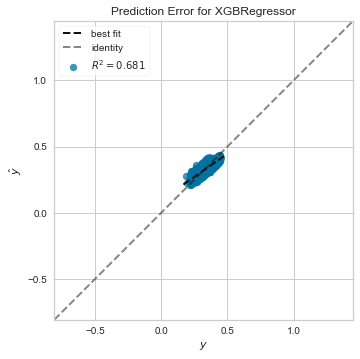

In [9]:
plot_model(model, plot='error')

In [175]:
pred = predict_model(model) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting Regressor,0.0141,0.0003,0.0181,0.6807,0.0137,0.0448


## Synthetic to Measurement Conversion

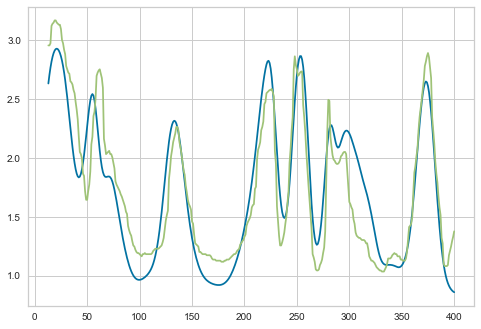

In [250]:
data_meas_dict = load_dataset('arduino_01', as_dict=False)

data = data_meas_dict[0]
delay = get_delay(data.vind.values, data.synth_vind.values)
vind = data.vind.values
if delay > 0:
    data = data.loc[delay:,:]
    data.vind = vind[:-delay]
else:
    data = data.loc[:-delay,:]
    data.vind = vind[delay:]

s = data.synth_vind
m = data.vind

a = np.std(s) / np.std(m)
b = np.mean(s) - np.mean(m)*a

plt.plot( s )
plt.plot( a*m + b )

In [24]:
def predict(x, y, win_size, step, doPlot=False, window_length=11):
    x_segmented = [ x[t:t+win_size] for t in range(0, len(y)-win_size, 1)]
    y_segmented = y[win_size:]
    data_n_df = pd.DataFrame( np.concatenate([x_segmented, np.reshape(y_segmented,(-1,1))], axis=1) )
    data_n_df.columns = [*['feature_'+str(i) for i in range(win_size)], 'target']

    prediction = predict_model(model, data=data_n_df)
    y_true = prediction.target
    y_pred = prediction.Label
    y_pred = signal.savgol_filter( y_pred, window_length=window_length, polyorder=1)  

    metrics = dict(
        r2 = r2_score(y_true, y_pred),
        mse = mean_squared_error(y_true, y_pred))

    if doPlot:
        plt.plot(y_true, label='True Value')
        plt.plot(y_pred, label='Prediction')
        plt.legend()
        plt.show()
    
    return y_true, y_pred, metrics

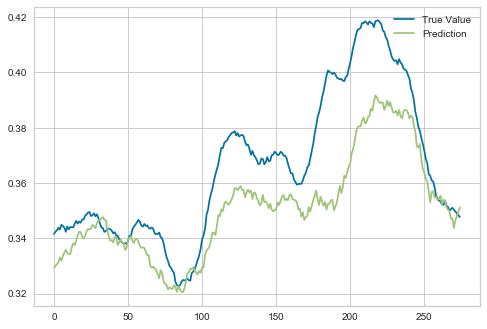

In [25]:
data = data_synth
n = 60
y_true, y_pred, metrics = predict(data.X[n], data.Y[n], win_size, step, doPlot=True, window_length=7)
   
   

# RNN

In [29]:
regressor = RNN(
    win_size = 40,
    step = 10,
    Nhiddenlayer = 20,
    Nunits = 50, 
    activation = 'tanh'
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 50)            20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 40, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 40, 50)            20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 40, 50)            20200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 40, 50)           

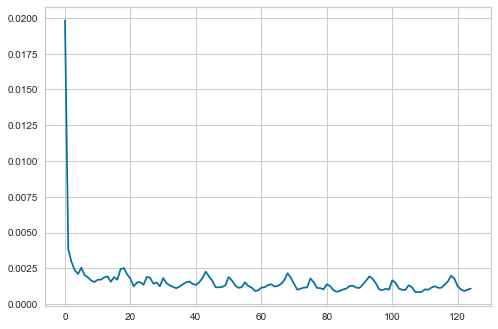

In [30]:
loss = regressor.train( data_synth, epochs=5 )

In [32]:
y_true = data_synth.Y[:5]
y_pred = regressor.predict(data_synth.X[:5,:])

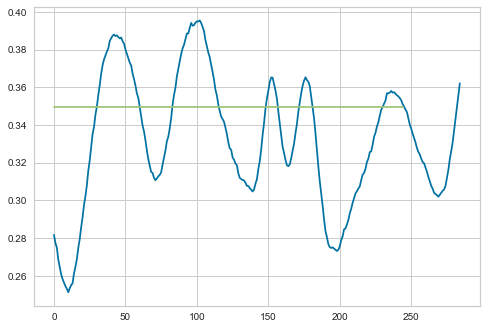

In [33]:
idx = 2
plt.plot(y_true[idx])
plt.plot(y_pred[idx])

In [35]:
idx = 2
data = data_meas

x, y = data.X[idx], data.Y[idx]
x = np.reshape(x, (1, np.shape(x)[0], np.shape(x)[1]))
y = np.reshape(y, (1, np.shape(y)[0]))

y_pred_ = regressor.predict(x)
smoothed_predictions = signal.savgol_filter( predictions[0], window_length=11, polyorder=1, axis=0)       

plt.plot(y[0,regressor.win_size:])
plt.plot(predictions[0])
plt.plot(smoothed_predictions)
plt.show()